In [13]:
!pip install pyDOE

In [2]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [12]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.2, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x,0.5,0.05).T

#collocation points for every position and every time
X, T = np.meshgrid(x,t)


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [13]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [14]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [15]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
        self.itera = 1
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=10 
        sigma2=0.25

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(self.itera, loss_value, loss_u, loss_f, error_vec)
        self.itera += 1

# *Solution Plot*

In [16]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.1s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.15s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [21]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 4000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
#solutionplot(u_pred,X_u_train,u_train)

1 2.5544101133210919 0.33464364950197206 2.21976646381912 4.581167280411911
2 0.88165478940220821 0.29352237278594 0.58813241661626814 2.957384530365427
3 0.663747391587746 0.28377890993922777 0.37996848164851821 2.336007137821129
4 0.5071095426051988 0.27818862014133727 0.22892092246386156 1.7380825888482545
5 0.40152708124195546 0.27629896743612642 0.12522811380582902 1.3825613907218617
6 0.28753828980216145 0.27394901368178681 0.013589276120374654 1.0341832834418234
7 0.28499904900348777 0.27534893466868754 0.0096501143348002132 1.0273412445523982
8 0.27617860823039742 0.27421341309406966 0.0019651951363277328 1.0068150121584387
9 0.27585543399900825 0.27408788098557391 0.001767553013434337 1.0028915941509695
10 0.27577085239682381 0.27406488297820047 0.0017059694186233158 1.0018541602174822
11 0.275436646929823 0.27403894286782793 0.001397704061995048 1.0011385305597755
12 0.27455152497540447 0.27399277003576772 0.00055875493963676093 1.0006634798269953
13 0.27437556159567883 0.273

99 0.27357045915924094 0.27344050734928044 0.00012995180996048313 1.023788182199948
100 0.27357043415074667 0.27343977052735463 0.00013066362339201771 1.0236560119413771
101 0.27357040173554836 0.273439311088135 0.00013109064741334561 1.0235023677909847
102 0.27357034321720192 0.27343912622183131 0.00013121699537060492 1.0232907012768226
103 0.27357021847453505 0.27343911051936509 0.00013110795516993662 1.023083695011677
104 0.27356983554666592 0.27343946409585818 0.00013037145080775463 1.0227244472584074
105 0.27356903439201868 0.27343995563660062 0.00012907875541806016 1.0224811536990068
106 0.27356705912987517 0.27343613999002481 0.00013091913985036638 1.0228489704455268
107 0.27356439043019248 0.27343867579105213 0.00012571463914036731 1.0226078102855796
108 0.27356238271243316 0.2734457644550719 0.00011661825736123351 1.0225832519518654
109 0.27356063531962527 0.27343936404493846 0.00012127127468682992 1.0230779909434928
110 0.2735593488416988 0.27344643198019919 0.000112916861499

196 0.27351821737120319 0.27342058085625293 9.7636514950278475e-05 1.0494428872758281
197 0.27351791974026712 0.27341790672085736 0.0001000130194097404 1.0502317092429985
198 0.27351777995699672 0.27341858945625641 9.9190500740292049e-05 1.0503488468211328
199 0.27351760329253322 0.27341931871143765 9.8284581095591563e-05 1.050395636320496
200 0.27351735993523496 0.27341742555339527 9.993438183968572e-05 1.0504104898232027
201 0.27351725999637955 0.27341334768988107 0.00010391230649849502 1.0507189826347318
202 0.27351691158139263 0.27341639628745551 0.00010051529393711554 1.0508188383516393
203 0.27351673461634118 0.27341723615646679 9.9498459874403086e-05 1.0508901052271313
204 0.27351642243562313 0.27341859438092186 9.7828054701253942e-05 1.051178423289243
205 0.27351590745514948 0.27341749567893953 9.8411776209958942e-05 1.0517544979810816
206 0.27351560734116964 0.27341844119403064 9.7166147138999618e-05 1.05183067663864
207 0.27351488643631483 0.27341783330921549 9.70531270993359

293 0.27348085895115348 0.2733889471243196 9.191182683389666e-05 1.0554871381721025
294 0.27348079111274559 0.27338803423506347 9.275687768211113e-05 1.0550983880042877
295 0.27348077593827114 0.27338987803132264 9.0897906948509777e-05 1.0552563695231068
296 0.27348074059686028 0.27338956415749838 9.11764393619215e-05 1.0550901474621963
297 0.27348066088918044 0.27338912780671321 9.15330824672284e-05 1.05482912685696
298 0.2734804991225484 0.27338942548466472 9.1073637883690435e-05 1.0541453617950312
299 0.27348002588385534 0.27338978892022009 9.023696363522219e-05 1.0528785683328457
300 0.27347936357344044 0.27339162803274841 8.7735540692039508e-05 1.0514096346180206
301 0.2734786968822277 0.27339128987940831 8.7407002819388737e-05 1.0511332410292635
302 0.27347833708399022 0.27338943171837515 8.8905365615048724e-05 1.0526557042343616
303 0.27347806850635303 0.27339127170177607 8.6796804576977078e-05 1.0532092906537993
304 0.27347781803226762 0.27339080695168411 8.7011080583486279e-05

390 0.27346412661897418 0.27335308915574147 0.00011103746323269961 1.0587131074127265
391 0.27346351665391516 0.27334846585630762 0.00011505079760755209 1.060171232164004
392 0.27346327131175574 0.27335178809499688 0.00011148321675886731 1.060650008420921
393 0.27346299857609174 0.27335302924986959 0.00010996932622214465 1.0614959803546238
394 0.27346279876493579 0.27335125490913076 0.00011154385580501911 1.0609167089114626
395 0.27346268877143326 0.27335295311005048 0.00010973566138279251 1.0598251615598715
396 0.27346256743302633 0.27335353970301979 0.00010902773000655837 1.0599928095877036
397 0.273462447497956 0.27335350233674416 0.0001089451612118334 1.060562376768832
398 0.27346225570828558 0.27335667537140163 0.00010558033688394973 1.0610630774207572
399 0.273462171902342 0.27335614263479041 0.00010602926755158735 1.0612436173526505
400 0.2734620483565714 0.27335684231777624 0.00010520603879514434 1.0612686992093119
401 0.27346183639372351 0.27335898836342482 0.00010284803029867

487 0.27343034513044695 0.27326861906062166 0.00016172606982531109 1.0723010910449469
488 0.27342966626191806 0.27326791820425556 0.00016174805766249235 1.071390699496371
489 0.27342904134188017 0.27327633276596136 0.00015270857591878989 1.0700968033048528
490 0.27342863488423008 0.27327351795531013 0.00015511692891997936 1.0696959885710187
491 0.27342823094800256 0.27327189403584473 0.0001563369121578048 1.0691774250537085
492 0.27342727652296506 0.27327134649590668 0.00015593002705839074 1.0680794252363643
493 0.27342605293435179 0.27326537249489208 0.00016068043945973595 1.0675184901963908
494 0.27342405915465684 0.27327548074996133 0.00014857840469548533 1.0666513241693976
495 0.27342209018346419 0.27328023404845136 0.00014185613501284088 1.0683208987394024
496 0.27342151552226412 0.27328513765179369 0.00013637787047046627 1.0691748702107013
497 0.27342070338731789 0.27328267012252894 0.00013803326478893267 1.0693409226904098
498 0.27342057032001227 0.27328656184607586 0.0001340084

584 0.27339452033893596 0.2732375818132729 0.00015693852566306591 1.0726633685987776
585 0.27339444974158245 0.27323812282512711 0.00015632691645534979 1.0724385724534629
586 0.27339441163057093 0.27323864644920864 0.00015576518136228065 1.0721098859560194
587 0.27339438521497439 0.27323739345334846 0.00015699176162593437 1.0720126054073373
588 0.27339434913035005 0.273238389818065 0.00015595931228509636 1.0714433081079284
589 0.27339429893307443 0.27323792487218712 0.00015637406088732283 1.0716267981384522
590 0.27339409033353246 0.27323480148365425 0.00015928884987822522 1.0726316281339454
591 0.27339394921812493 0.2732344936143159 0.00015945560380904218 1.0731719627813083
592 0.27339377465128212 0.27323497675420305 0.00015879789707907811 1.0734376197367008
593 0.27339361490696928 0.27323531033717069 0.000158304569798584 1.0737273152589673
594 0.27339351356323133 0.27323985576370052 0.00015365779953079462 1.073221854473615
595 0.27339342001750316 0.27323478410427271 0.000158635913230

681 0.27336592285568723 0.27320811234730508 0.00015781050838212986 1.086407854093954
682 0.27336559459820381 0.27320715106057741 0.00015844353762639525 1.0863747412877667
683 0.27336526960846125 0.27321090280103472 0.00015436680742651854 1.085823277111586
684 0.27336482154123304 0.27320601080329016 0.00015881073794287242 1.0861554878896489
685 0.27336448412109154 0.27321173684459821 0.00015274727649332051 1.0848526309050948
686 0.27336425793777364 0.27321201974369663 0.00015223819407700652 1.0844937540311135
687 0.27336401958350209 0.27320986503165751 0.00015415455184459375 1.0854127147740877
688 0.27336382213529981 0.27321198906248723 0.00015183307281260524 1.0853267821001722
689 0.27336359866045551 0.27321277237763597 0.00015082628281954809 1.0854126316704071
690 0.27336347020669205 0.27321633462567591 0.00014713558101616051 1.085177747046342
691 0.2733633794672759 0.27321465431917519 0.00014872514810069948 1.0849582692827557
692 0.27336328307927282 0.27321482688792631 0.000148456191

777 0.27330616416424486 0.27310414931725641 0.00020201484698843754 1.1192735737005541
778 0.27330553273929326 0.27310139856539051 0.00020413417390273533 1.1201916005651316
779 0.27330513130638734 0.27310184383884828 0.00020328746753903217 1.1208914441537279
780 0.27330501808352736 0.27309907864805449 0.00020593943547286516 1.1223682249899847
781 0.27330477320865659 0.273098873481515 0.00020589972714160545 1.122761688971379
782 0.273304682610964 0.27309910787009212 0.0002055747408718914 1.1230282180494862
783 0.27330463567755714 0.27309863108260107 0.00020600459495608806 1.1231991272688315
784 0.27330459364012272 0.27309887477291389 0.00020571886720880127 1.1232035107088747
785 0.27330454507386381 0.27309948460567213 0.00020506046819168374 1.122909754666512
786 0.27330450112108623 0.27310036311747177 0.00020413800361444577 1.1224967160172248
787 0.27330444519341646 0.27310090368077616 0.00020354151264029375 1.122138703311361
788 0.27330430129628464 0.2731016738105192 0.00020262748576542

874 0.2732283225048876 0.27299754373927454 0.00023077876561305465 1.1444411494243591
875 0.27322684656046803 0.27299622189465822 0.00023062466580982534 1.1426058427192913
876 0.27322508424837738 0.27299911884382994 0.00022596540454742644 1.1398955378546856
877 0.27322364397831783 0.27299879487363343 0.00022484910468440234 1.141021606975516
878 0.27322256861993133 0.27299242417608649 0.00023014444384486066 1.1401016916771674
879 0.27322193577745812 0.27300256422935959 0.00021937154809855544 1.1347292414877315
880 0.273220534973057 0.27299649563094885 0.00022403934210811347 1.1366968278276404
881 0.27321990590630013 0.27299256325591292 0.0002273426503871846 1.1367903706203617
882 0.27321924110495222 0.27299633420259323 0.0002229069023589626 1.135135312645878
883 0.27321844084733826 0.27299605680768163 0.00022238403965663434 1.133610366461609
884 0.27321774043739511 0.2730002327531702 0.0002175076842249081 1.1322852990243422
885 0.27321602351275814 0.27300236816494183 0.000213655347816316

971 0.27312664099221795 0.27296154137969936 0.00016509961251861966 1.1775662675572678
972 0.27312611243491797 0.27295992924192347 0.0001661831929944846 1.1742740623867898
973 0.27312584398645545 0.27295844266005909 0.00016740132639634359 1.174168786892866
974 0.27312561906058369 0.27295525128952264 0.00017036777106105638 1.173810656356322
975 0.27312536085916922 0.27295275369510796 0.00017260716406125736 1.174283645114648
976 0.27312494166440843 0.27294711563351332 0.00017782603089512797 1.1752137849729214
977 0.27312431254962211 0.27294264656470879 0.00018166598491333876 1.1771571810331833
978 0.273123920746403 0.27293497594973665 0.00018894479666634907 1.1799971603483184
979 0.27312315491292133 0.27294116477342334 0.00018199013949801688 1.1812109951169552
980 0.2731228597308204 0.27293714715943385 0.00018571257138656164 1.1801049368965064
981 0.27312268782286764 0.27293505598421142 0.00018763183865620124 1.1796698504970828
982 0.27312251771764068 0.27293857962592549 0.000183938091715

1067 0.27303759962519514 0.27276109687835681 0.00027650274683831041 1.2509795615208361
1068 0.27303596325856788 0.27275859090284488 0.00027737235572302348 1.249588055682874
1069 0.27303545821056885 0.27274106526169672 0.00029439294887211877 1.2505989117904488
1070 0.27303346618241547 0.27274844598820275 0.00028502019421270731 1.251986784325873
1071 0.27303250833940362 0.27273721435166565 0.00029529398773798019 1.2564555610020107
1072 0.27303077498960943 0.27273776486098833 0.00029301012862108434 1.2574426726337453
1073 0.27302971702895568 0.27271582294167174 0.00031389408728393545 1.2641744703357156
1074 0.27302768250229487 0.27270909031373508 0.000318592188559785 1.2656524795145996
1075 0.27302672418918894 0.27270692825852128 0.00031979593066766543 1.2663238056974562
1076 0.27302497143029719 0.27269177893907603 0.00033319249122116152 1.273714760498894
1077 0.27302403754360821 0.27270058234983108 0.00032345519377710704 1.2715073005719482
1078 0.27302352760148152 0.27269748548043493 0.0

1162 0.27277290146125044 0.2721289590651495 0.0006439423961009282 1.3276863989058114
1163 0.2727535215825817 0.27212371663846813 0.00062980494411359251 1.3224914870252729
1164 0.27274244354037686 0.27211533269888305 0.00062711084149381533 1.3102756528954898
1165 0.27273724790181053 0.27212622375245227 0.00061102414935823731 1.312046204917892
1166 0.27272325203614967 0.27209323948962549 0.00063001254652416555 1.3062337524564813
1167 0.27270299333314751 0.27205817390945208 0.00064481942369541689 1.318901943797695
1168 0.27268141972583365 0.272047503310179 0.00063391641565463614 1.3381885492106933
1169 0.27266779951110293 0.27201191503232969 0.00065588447877321522 1.344779963616953
1170 0.2726436374978623 0.27206408381730335 0.00057955368055893062 1.332605146774482
1171 0.2726250006363854 0.27204261211094111 0.00058238852544428062 1.3179830689594454
1172 0.27260495478195179 0.27202363881599462 0.00058131596595719531 1.3042024176325548
1173 0.27257107952273973 0.27196604392817342 0.0006050

1259 0.25939610687408571 0.25380272033236978 0.0055933865417159114 4.649269638187571
1260 0.25922837233373147 0.25359240327059779 0.00563596906313371 4.657350936378678
1261 0.25901985166685459 0.25352193694951963 0.0054979147173349592 4.614162156735353
1262 0.25891012447575168 0.25321453460334858 0.0056955898724030734 4.665423839783369
1263 0.25875502564588265 0.25287140469710656 0.0058836209487761011 4.702161223617788
1264 0.25861315845300542 0.25296789205663556 0.00564526639636985 4.702137669611472
1265 0.25837877406237286 0.25275721802204143 0.0056215560403314125 4.794889325694431
1266 0.25816518395747096 0.25250087229478041 0.0056643116626905665 4.913336997711374
1267 0.25802030646901286 0.25279715230311961 0.0052231541658932625 4.972309088561083
1268 0.25783277572509183 0.25255854479799295 0.0052742309270989 5.041283955778717
1269 0.25777253437634684 0.25184717590860267 0.005925358467744145 5.060032911933347
1270 0.25759998229893977 0.25206765605486037 0.0055323262440794248 5.0801

1357 0.23652182723305987 0.22495122303952933 0.011570604193530525 8.35957065095178
1358 0.23636960648067351 0.22468234423797945 0.011687262242694063 8.413762876773793
1359 0.23611430354603943 0.22463534794494913 0.011478955601090296 8.432372667191858
1360 0.23596543210427934 0.22450224848303649 0.011463183621242849 8.486959275411971
1361 0.23575911505190444 0.22501071587785129 0.01074839917405316 8.471405325391444
1362 0.23551911954039798 0.22481933926701611 0.01069978027338186 8.536642374565258
1363 0.23492326551999138 0.22437675152708095 0.010546513992910438 8.69629787037725
1364 0.23455273989051953 0.22350404144472627 0.01104869844579327 8.84439251698094
1365 0.2340453498846172 0.22342975039399149 0.010615599490625722 8.74566365084911
1366 0.23345604704800205 0.22309993086423618 0.010356116183765854 8.674597779311153
1367 0.23275929232718442 0.22152902566822391 0.011230266658960524 8.774331718891187
1368 0.23185020894817371 0.22034856560282678 0.011501643345346927 8.897465023268117


1455 0.19010259691557563 0.16518607878875491 0.024916518126820712 11.16269392650336
1456 0.18868240695333457 0.16140632802566282 0.027276078927671765 11.53197450031889
1457 0.18660015839741598 0.16007670431353219 0.026523454083883791 11.621117379382637
1458 0.18426089449790334 0.15811574750397608 0.026145146993927251 11.62297058454802
1459 0.18293364597529513 0.15538141580459239 0.027552230170702737 11.769600630385284
1460 0.18165014782352357 0.15251412535149544 0.029136022472028136 11.96024001998651
1461 0.18064729378765043 0.15095620329781884 0.029691090489831609 11.96357094979391
1462 0.17910873310178538 0.14662427232449335 0.032484460777292015 12.198439323336865
1463 0.17733653970100122 0.14260624735759347 0.03473029234340775 12.431724398969441
1464 0.17504120624397898 0.13801064929124238 0.037030556952736604 12.679840980484233
1465 0.17437037158517693 0.13846517741547126 0.035905194169705675 12.628107157410396
1466 0.17348497577011185 0.13875781659494926 0.034727159175162593 12.54

1552 0.10245724744651814 0.086224273548141842 0.016232973898376298 18.268227976373502
1553 0.10216109155835559 0.086138193464546348 0.016022898093809246 18.309109448556928
1554 0.10189948045455446 0.085673830769896181 0.016225649684658276 18.564235783808602
1555 0.10143823798895146 0.08539947427218722 0.016038763716764246 18.603359635475346
1556 0.10086954843327116 0.085150605457701256 0.015718942975569906 18.53824457486108
1557 0.10047641794851893 0.084790986857096462 0.01568543109142247 18.667073794284903
1558 0.10005023700617999 0.084298740587282914 0.015751496418897067 18.84678545033023
1559 0.0997604305416372 0.084351075231609465 0.015409355310027739 18.851077568343864
1560 0.099448808574296943 0.084549801121992327 0.014899007452304609 18.79340633066392
1561 0.09927000954247639 0.084714042430705253 0.014555967111771132 18.734390093885292
1562 0.099043283636688351 0.084851952650750032 0.014191330985938323 18.776833131791424
1563 0.098926708921068543 0.084853102067264582 0.014073606

1647 0.079528816537603519 0.0726774008759244 0.0068514156616791078 20.82817190712265
1648 0.079262100070897984 0.072194266538338783 0.0070678335325592076 20.92198045097381
1649 0.078903774379926309 0.071357774489393566 0.0075459998905327485 21.1184313539587
1650 0.078510222303970312 0.070606243693840484 0.0079039786101298311 21.315198733330682
1651 0.077969937498947151 0.069583981926949451 0.0083859555719976962 21.650500472185012
1652 0.077687840311421827 0.069008677610896824 0.008679162700525 21.940823607011577
1653 0.077128558241686088 0.069356039596228991 0.0077725186454570931 21.959295352371996
1654 0.077006244494914972 0.06918777026731715 0.0078184742275978283 22.030526500060812
1655 0.076773868656514033 0.069010577262943434 0.0077632913935706035 22.125334681105972
1656 0.076569500017121372 0.068742859045205593 0.0078266409719157763 22.308700362755793
1657 0.076239400939873636 0.068592079847518667 0.0076473210923549686 22.51612389898307
1658 0.075888636652874264 0.0684536545862270

1743 0.069013630173462182 0.063632577189011066 0.0053810529844511091 25.00025917059654
1744 0.06897609337618639 0.063608260073981321 0.0053678333022050672 24.98973721829424
1745 0.068891114322232522 0.0635419213636167 0.0053491929586158239 24.929720149400627
1746 0.068731348535284134 0.0633824756695686 0.0053488728657155342 24.81688771654441
1747 0.068508855103495345 0.063107117491890422 0.0054017376116049275 24.643309932187865
1748 0.068409916460239834 0.062947639187951016 0.0054622772722888223 24.53734532206739
1749 0.068213149407685636 0.062594517366485442 0.0056186320412001875 24.34886358245242
1750 0.068173177706110172 0.062544912110879522 0.0056282655952306455 24.3411756642641
1751 0.068079098605688143 0.062636019158669759 0.0054430794470183771 24.3572529531184
1752 0.068026269632803671 0.062648236389209036 0.0053780332435946314 24.290249635413847
1753 0.0679772037048176 0.062730490184032428 0.0052467135207851625 24.179047423454698
1754 0.067897313396991385 0.062741141541298867 0

1838 0.065317406617751983 0.061183752069301392 0.0041336545484505936 24.656835388786362
1839 0.065269124716531735 0.06122875835031609 0.0040403663662156378 24.579713156900972
1840 0.065223822739629858 0.061308315304174257 0.0039155074354555947 24.536736498579508
1841 0.065207856919489326 0.061320491596691853 0.0038873653227974696 24.51892338883536
1842 0.065175706031759637 0.0613979507944391 0.0037777552373205411 24.493901128905843
1843 0.0651460478205026 0.061332498410751848 0.0038135494097507445 24.490733537320935
1844 0.065117276843077651 0.061292089057929926 0.0038251877851477314 24.537752534471096
1845 0.065040735658721344 0.061223356634700493 0.0038173790240208466 24.56129746375309
1846 0.064987014920465477 0.061124257321304325 0.0038627575991611513 24.527327166140196
1847 0.064917936173952029 0.060851346160397966 0.0040665900135540608 24.524547280215753
1848 0.064853979223909786 0.0605494369766175 0.0043045422472922923 24.517628521539383
1849 0.064799891545938418 0.0604828760746

1933 0.061236175887290863 0.056551803771091445 0.0046843721161994164 23.5510898993513
1934 0.061206134480882544 0.056585175908171914 0.0046209585727106295 23.51531782676437
1935 0.061190693608161789 0.056554179509566579 0.0046365140985952071 23.455144307522623
1936 0.061172519717063514 0.056556377521040181 0.004616142196023334 23.47636904679602
1937 0.061162663865185776 0.056522395392596757 0.00464026847258902 23.472762999545765
1938 0.061149890147473629 0.056485999838761611 0.0046638903087120216 23.475136240973843
1939 0.061134089626889758 0.056401788443146972 0.004732301183742787 23.49280704576163
1940 0.061109383215482989 0.056303400152716322 0.0048059830627666666 23.52272178870194
1941 0.061093173261330069 0.056206695210002093 0.0048864780513279762 23.52053972894049
1942 0.061051516248659662 0.056025332045350151 0.0050261842033095146 23.529083149464185
1943 0.061009129767854706 0.055876928393068175 0.0051322013747865337 23.48675169954649
1944 0.060981657278383929 0.0557320716925970

2028 0.056052424283528 0.049413722713713318 0.0066387015698146879 22.886304406323735
2029 0.056022434360038481 0.0493742236719873 0.0066482106880511784 22.891153765311348
2030 0.055992805769672707 0.049238245641653008 0.006754560128019697 22.88063849221099
2031 0.055962118066763579 0.049161336316754449 0.00680078175000913 22.946415609099706
2032 0.055923568942393143 0.049137659711999938 0.0067859092303932016 22.920560751209354
2033 0.055887695248131523 0.049060615811655391 0.0068270794364761319 22.88367028521215
2034 0.055863415810552777 0.049076795852998643 0.0067866199575541348 22.892480310860215
2035 0.055849902281856552 0.049019292311464534 0.00683060997039202 22.927416315491524
2036 0.055837642349596886 0.048971141206469844 0.0068665011431270385 22.93780649178537
2037 0.055827017691818609 0.048897693696357887 0.00692932399546072 22.92133852242866
2038 0.055805964958108883 0.048926162533301024 0.0068798024248078607 22.912751962967537
2039 0.055779744682666423 0.048968525151743145 0

2123 0.050888585133114915 0.043744586737679891 0.0071439983954350236 23.284596664607644
2124 0.050873150510664156 0.043624060592484769 0.0072490899181793834 23.20198812797084
2125 0.050857874656831246 0.043501660694180516 0.0073562139626507286 23.181886578099483
2126 0.050842568065087919 0.043420974259019633 0.0074215938060682883 23.179491921966655
2127 0.050827858431169749 0.043275107264298195 0.0075527511668715538 23.216007548878746
2128 0.050811465891896022 0.043277783860701538 0.0075336820311944861 23.23194937688823
2129 0.050782625865071054 0.043255051449883758 0.007527574415187299 23.23889083360481
2130 0.050735706381596295 0.043192901778106939 0.0075428046034893568 23.248340203015697
2131 0.050700022515399179 0.04321134646158984 0.0074886760538093351 23.23645442154005
2132 0.0506478889372731 0.043040600089651958 0.0076072888476211428 23.26932332517941
2133 0.050608681509080017 0.04306812138562905 0.007540560123450969 23.309345965384544
2134 0.05054431178084022 0.0430738153796477

2218 0.046425331124308307 0.039543460386815894 0.0068818707374924152 23.507392337833995
2219 0.046403584050776756 0.039477168271646816 0.006926415779129942 23.493947439625487
2220 0.04637560446934335 0.039294660809951948 0.0070809436593914019 23.41561273471385
2221 0.046357482239159031 0.039277204347983589 0.0070802778911754427 23.4130064461685
2222 0.046341833585704914 0.039203800301256565 0.00713803328444835 23.43432258174022
2223 0.046335925080451465 0.039183129728698689 0.0071527953517527736 23.447300263805257
2224 0.0463238409871402 0.039192431506354326 0.0071314094807858729 23.433616638366598
2225 0.046316060900606922 0.039229351119372854 0.0070867097812340654 23.449632520324435
2226 0.046303387905953043 0.039254300739460922 0.0070490871664921195 23.471615234879838
2227 0.04628187026342305 0.039305280899010323 0.0069765893644127249 23.50219258281216
2228 0.046264378345259115 0.0393410655799838 0.0069233127652753162 23.545762598215596
2229 0.046238328766958686 0.039279411137879069

2313 0.042939346474350319 0.036484255592822687 0.0064550908815276331 23.214491191959937
2314 0.042905363892092013 0.036539325360334982 0.00636603853175703 23.218522852650256
2315 0.042874621283308705 0.036495244013481455 0.00637937726982725 23.21493716994674
2316 0.042851540977977033 0.036533290931983466 0.00631825004599357 23.164093704759633
2317 0.042826122407112206 0.036552337496251808 0.0062737849108603994 23.156330214755155
2318 0.042800217277693661 0.036541736962782158 0.0062584803149115 23.146222340949993
2319 0.042782195718556466 0.036590598776108055 0.0061915969424484142 23.14449659948526
2320 0.042751201039407868 0.036544882921974595 0.0062063181174332712 23.161797089329106
2321 0.042725100693872933 0.036588107520119581 0.0061369931737533506 23.16237677178926
2322 0.042667231525500157 0.036685229191898087 0.0059820023336020723 23.16504942323763
2323 0.042617528627723063 0.036787759688749519 0.0058297689389735464 23.1819723366979
2324 0.042580196374276791 0.036765143035189227 

2408 0.038335228509674933 0.030315306758574224 0.0080199217511007087 23.31728764438988
2409 0.038318969320081178 0.030345112366081495 0.00797385695399968 23.381098517289903
2410 0.0383000738991733 0.030327450001726038 0.0079726238974472622 23.402522373479187
2411 0.0382846212141023 0.030327463178649854 0.00795715803545245 23.438883074678476
2412 0.038268450065750539 0.030277909793055155 0.0079905402726953845 23.485566386405708
2413 0.03824838057516923 0.030261975824361832 0.0079864047508073945 23.515243106722107
2414 0.038214757436496841 0.030165573879385663 0.0080491835571111746 23.533894095434643
2415 0.03814483026722211 0.030006461722394111 0.0081383685448279969 23.544492075001436
2416 0.038071230011376189 0.029808245242505218 0.0082629847688709731 23.50053609660138
2417 0.038011455279092068 0.029710480176229844 0.0083009751028622278 23.52385825374365
2418 0.037938480063906446 0.029646048398965667 0.0082924316649407755 23.49211887535308
2419 0.037834800471079323 0.029591585255295275

2503 0.034973887464170364 0.025163889626344752 0.0098099978378256153 22.888979966071293
2504 0.034933199730590975 0.025007996143110309 0.009925203587480667 22.97996922115667
2505 0.034903504382045938 0.025013399522884405 0.0098901048591615356 23.020668214576617
2506 0.0348223336907704 0.024973370710185256 0.0098489629805851488 22.983172911899636
2507 0.034765444589685682 0.024856862544643032 0.0099085820450426475 22.968189071781936
2508 0.034679972766027439 0.0247140835977624 0.0099658891682650377 23.05091726617087
2509 0.034585263489487011 0.024550935856129174 0.010034327633357838 23.083293341673134
2510 0.0345401132214984 0.024577846858328967 0.00996226636316943 23.098838022698928
2511 0.03449722549441725 0.024643670250440244 0.009853555243977007 23.090102608092465
2512 0.034460399789754431 0.024936009141085989 0.009524390648668439 23.085154164591078
2513 0.034388622798580536 0.024888632020779074 0.0094999907778014619 23.05577782662443
2514 0.034331404401987939 0.02471596286657193 0.

2598 0.030038893815038142 0.020250751185188931 0.00978814262984921 22.66249630556007
2599 0.029993203762415217 0.020198587724433743 0.0097946160379814746 22.689173193068484
2600 0.02991878399484544 0.02020985744083666 0.0097089265540087778 22.69127360642491
2601 0.029839918883489667 0.02018161413983147 0.009658304743658197 22.635406575705417
2602 0.029756218002928929 0.020149022714207165 0.0096071952887217624 22.616599009714133
2603 0.029707871345793481 0.020189528088814874 0.0095183432569786054 22.627362503537515
2604 0.029643175413995894 0.020207704046801913 0.0094354713671939826 22.642811526620658
2605 0.029584986694816025 0.02029207199176836 0.0092929147030476628 22.6592622814949
2606 0.029563396152158444 0.020478014145244253 0.0090853820069141909 22.68850315733096
2607 0.029495454181250526 0.020548270014430364 0.00894718416682016 22.67009750029962
2608 0.029467174917205161 0.020628183525007143 0.008838991392198018 22.692002715227662
2609 0.029426800250562306 0.020838584973413728 0

2693 0.026355209411198652 0.018962715837456647 0.0073924935737420044 22.868700104665276
2694 0.026305222036924144 0.018890472989127983 0.0074147490477961611 22.889104033655563
2695 0.026268029543084333 0.018814024411266828 0.0074540051318175062 22.90097212914926
2696 0.0262079426057025 0.018628094963762807 0.0075798476419396922 22.90778821158194
2697 0.026097543121603343 0.018259042676360186 0.0078385004452431566 22.982241144971823
2698 0.026041062447643721 0.018208109225439282 0.007832953222204439 23.00887780175727
2699 0.025989508221744211 0.018143419380466406 0.0078460888412778054 23.01032762253245
2700 0.025940021490983307 0.018114251852886093 0.0078257696380972137 23.050210913810393
2701 0.02591062110032212 0.018066228087337169 0.0078443930129849532 23.072185451186574
2702 0.025875910050747637 0.018087153628857881 0.0077887564218897557 23.07770056943623
2703 0.025832808431770188 0.018043200319217977 0.0077896081125522123 23.115964472827123
2704 0.02577374880796628 0.01806944636961

2788 0.022663447878186305 0.014715587640693712 0.0079478602374925943 22.906137804965166
2789 0.022637496266791207 0.014777965029510879 0.0078595312372803285 22.921189095019187
2790 0.022604490572641314 0.014816057542596614 0.0077884330300446994 22.898560912438594
2791 0.022583446748060666 0.014840398994603253 0.0077430477534574131 22.869456748604524
2792 0.022559997320753512 0.014916651909842227 0.0076433454109112843 22.832828331428757
2793 0.022540883258035011 0.014938563971534514 0.0076023192865004967 22.801611324093727
2794 0.022520618003689617 0.014972228428390974 0.0075483895752986438 22.785445649632543
2795 0.022492713446964078 0.015089869014399416 0.0074028444325646616 22.73370036921779
2796 0.022466992748324286 0.015150157002717296 0.0073168357456069892 22.7357586752071
2797 0.022435715047990686 0.015227045446898405 0.0072086696010922819 22.734814805022356
2798 0.022401827680953765 0.015338887469221301 0.0070629402117324625 22.733132817192665
2799 0.022380236111807349 0.0153731

2883 0.019738492374318267 0.013055487175577528 0.0066830051987407388 22.917495545079827
2884 0.019723879518228661 0.013008013327448095 0.0067158661907805676 22.945835301753636
2885 0.019700449309591753 0.013007689492841226 0.0066927598167505287 22.964528814321227
2886 0.019675678876092215 0.013009684204348157 0.0066659946717440568 22.942070292260382
2887 0.019651150286980057 0.013005963836522548 0.0066451864504575089 22.937503197899275
2888 0.019604030013152383 0.013037346571185585 0.0065666834419667985 22.92826192023204
2889 0.019553985395174188 0.013096446136682906 0.0064575392584912822 22.865711838301266
2890 0.0195218514884425 0.013136292989209535 0.0063855584992329661 22.809235884199644
2891 0.019486723268865445 0.013125215686320902 0.0063615075825445436 22.79686165678461
2892 0.0194658506495581 0.013037469752715549 0.0064283808968425508 22.78734759795159
2893 0.019453622578696369 0.012978896376529206 0.0064747262021671633 22.789240365564115
2894 0.019438290148769015 0.01293281233

2978 0.017384168721782247 0.010930746765554684 0.0064534219562275633 22.717276086389482
2979 0.017360590413649988 0.010799526056561357 0.0065610643570886322 22.726314255251644
2980 0.017345303355281689 0.010697898627325389 0.0066474047279562994 22.722585671021957
2981 0.01732340304611895 0.01060157351903564 0.0067218295270833088 22.708749431676583
2982 0.01729953516138643 0.010451979543774527 0.0068475556176119026 22.706714513025265
2983 0.017268036669113959 0.010330964534303379 0.006937072134810581 22.713257610084508
2984 0.017239166932149504 0.010203605908711456 0.0070355610234380467 22.750088760030533
2985 0.017205334587740831 0.010124348379138016 0.0070809862086028165 22.763463532873732
2986 0.017175090172792083 0.010077733769948674 0.0070973564028434079 22.742971815013362
2987 0.017144917879983426 0.0099668714963275715 0.007178046383655854 22.734254218982507
2988 0.017111005012371647 0.0098900682206285468 0.0072209367917431 22.703474977630137
2989 0.01707722312064841 0.00997746100

3072 0.014513143204161852 0.0085047158364049153 0.0060084273677569362 22.708376616192265
3073 0.014510840988836027 0.0084204411721927365 0.0060903998166432919 22.704403271933288
3074 0.014468588648305998 0.0085103817513938144 0.005958206896912184 22.70443732456378
3075 0.014461404988362814 0.0085031621948504221 0.005958242793512392 22.6876624366341
3076 0.014449977901012215 0.0085497604679017 0.0059002174331105146 22.68460008501153
3077 0.014441718222036791 0.0085451734517313811 0.0058965447703054107 22.686100566215845
3078 0.014429874217298942 0.00851786291247702 0.00591201130482192 22.67837717153851
3079 0.014411465834296651 0.00843889416063256 0.0059725716736640918 22.667104373931117
3080 0.014387989872687953 0.008330075121590572 0.0060579147510973815 22.68204645417959
3081 0.014359632182738457 0.00820368711205689 0.0061559450706815668 22.68048591325142
3082 0.014333533593619083 0.0081122876441366738 0.0062212459494824087 22.71286364430867
3083 0.014319176834641539 0.008011961200605

3166 0.011970776433917921 0.0063607211270893388 0.0056100553068285835 23.403484851351504
3167 0.011946454963911779 0.0063072911577742733 0.0056391638061375057 23.41658272565244
3168 0.011914008732096682 0.0062950412632211137 0.0056189674688755676 23.39527265094423
3169 0.011900500870980307 0.006296977041376297 0.00560352382960401 23.399769908714642
3170 0.01187086396935446 0.0062568142764359846 0.0056140496929184755 23.425042742711778
3171 0.011861754459462852 0.0062686302125907686 0.0055931242468720832 23.402961814760594
3172 0.011843132228089557 0.0062436927263000812 0.0055994395017894757 23.418987737469596
3173 0.011834763080140278 0.0061967176866998845 0.0056380453934403944 23.43772340327596
3174 0.011821528293163734 0.0061840821181554208 0.0056374461750083125 23.443243289182462
3175 0.011808544027817058 0.006141800915916317 0.0056667431119007414 23.454366268056308
3176 0.011795102340729413 0.0060836358860055688 0.0057114664547238446 23.463674947135278
3177 0.011777045676509133 0.0

3260 0.01025958345907205 0.0046291890302338819 0.0056303944288381685 23.306459550203503
3261 0.010250379657968704 0.0045826481633450093 0.0056677314946236958 23.329446726218542
3262 0.010235239090665524 0.0045942687013007773 0.0056409703893647457 23.32466088890424
3263 0.010225298051739332 0.0045613759398773872 0.005663922111861946 23.316396289377227
3264 0.0102136085151526 0.0045169546838797862 0.0056966538312728148 23.31702644528197
3265 0.010202704206171963 0.004417255528365964 0.0057854486778059992 23.336681822236145
3266 0.010188480449508711 0.0044243894673010277 0.0057640909822076827 23.336865512237857
3267 0.010174795184017409 0.0044367871760484867 0.0057380080079689226 23.30687400125333
3268 0.010156388194499742 0.0043910388143069837 0.005765349380192757 23.281394489823185
3269 0.010136117503312964 0.0043319159609470619 0.0058042015423659023 23.2310643336062
3270 0.010120778783595982 0.0043313679236748363 0.0057894108599211456 23.182430899219938
3271 0.010103675917525336 0.0043

3353 0.00892061288442093 0.0038598567235019667 0.0050607561609189644 22.75983383828189
3354 0.0089169137688821648 0.0038569306850066206 0.0050599830838755433 22.754543187163968
3355 0.0089132634666740269 0.0038542892443662051 0.0050589742223078223 22.74862399991667
3356 0.0089082373298806621 0.0038524709865990184 0.0050557663432816433 22.741161650595252
3357 0.0088991540771524782 0.0038511309719531815 0.0050480231051992959 22.7267318439856
3358 0.0088876068947867735 0.0038437223327998679 0.005043884561986906 22.71815374812338
3359 0.0088773777198025618 0.0038436993562985986 0.0050336783635039637 22.70499438872875
3360 0.008870862095107606 0.0038309188212830407 0.0050399432738245644 22.70776955268824
3361 0.00886399325668015 0.0038219406100581388 0.005042052646622012 22.695019628984536
3362 0.00885595974035247 0.0038146574885787356 0.0050413022517737357 22.684594685869136
3363 0.0088495151111380142 0.0038159932989220479 0.0050335218122159664 22.666171698616356
3364 0.0088416712816694887

3446 0.0075270533559929778 0.0027160935796315391 0.0048109597763614387 22.608160211993066
3447 0.0075177128024706552 0.0026825665975574874 0.0048351462049131683 22.617682579187363
3448 0.0075052889319574961 0.0026496850383821023 0.0048556038935753934 22.62291432792759
3449 0.0074927139018776236 0.0026095277682003813 0.0048831861336772423 22.633849819713042
3450 0.007490313973577566 0.0025996131185086675 0.0048907008550688989 22.622383018232213
3451 0.0074817303653008441 0.0025915273981892235 0.0048902029671116206 22.63650481254463
3452 0.0074773285645551163 0.0025930660587619009 0.0048842625057932158 22.642379335379786
3453 0.0074729041143576751 0.0025935600541083341 0.004879344060249341 22.649699277730452
3454 0.0074662094492584773 0.0025667678841523123 0.004899441565106165 22.658683164975677
3455 0.0074589096222859976 0.0025353344021737181 0.0049235752201122794 22.648978908787893
3456 0.0074502751165221011 0.0024926410827178424 0.0049576340338042587 22.648051705095614
3457 0.00744517

3539 0.0066066274611413069 0.0022658766564413839 0.004340750804699923 22.789000270689524
3540 0.0065936720615375338 0.0022390526260338815 0.0043546194355036528 22.798659446559046
3541 0.0065789103819508706 0.0022371347082574705 0.0043417756736934 22.78100488673333
3542 0.00656587430366515 0.0022477912081098946 0.004318083095555255 22.755800827535023
3543 0.0065564157641267041 0.00227482029908666 0.0042815954650400438 22.756738347988172
3544 0.0065492839277992571 0.0022866395866671624 0.0042626443411320943 22.748735678372093
3545 0.0065397882562562223 0.0022904239681067451 0.0042493642881494768 22.767000499701428
3546 0.0065280090775966422 0.0022781800383256173 0.0042498290392710249 22.78995019547127
3547 0.0065161199016448394 0.0022423025678840673 0.0042738173337607717 22.81371949591283
3548 0.0065069673460930785 0.0022367638336045323 0.0042702035124885457 22.833393344770684
3549 0.0064937280521569288 0.0022318626086377772 0.0042618654435191512 22.80857614425775
3550 0.0064804585361676

3632 0.0052073348749915021 0.0013891785822181082 0.0038181562927733937 22.657805806960877
3633 0.0052049082912906525 0.0013673273083351714 0.0038375809829554815 22.66627046180668
3634 0.0052025422213964135 0.0013649390486753096 0.0038376031727211041 22.674602894658285
3635 0.0051993262895730745 0.0013683893341320066 0.0038309369554410675 22.679553625466546
3636 0.0051927809336454554 0.0013779190704559861 0.0038148618631894688 22.682755223139832
3637 0.00518619618632272 0.0013775893192759642 0.003808606867046756 22.662906338888128
3638 0.0051806249315923258 0.0013799635911007364 0.0038006613404915892 22.634461406134825
3639 0.0051720355918065787 0.0013863073567236021 0.0037857282350829769 22.61344783329853
3640 0.0051658225618559511 0.0013556853502766143 0.0038101372115793364 22.611895706123583
3641 0.0051550612208299557 0.0013325167889800343 0.0038225444318499215 22.611392359593662
3642 0.0051483890308241815 0.0013287779234129203 0.003819611107411261 22.605099258879658
3643 0.005141648

3724 0.0045481471618348829 0.0011801938278404619 0.0033679533339944214 22.636603556671744
3725 0.00454465285736327 0.0011855958242363975 0.0033590570331268731 22.629961402927158
3726 0.0045407961176672854 0.0011898793405084702 0.0033509167771588154 22.626040380422324
3727 0.0045367908590452748 0.0011837694163076315 0.0033530214427376429 22.62179377291828
3728 0.0045320787008902557 0.0011844256232472409 0.0033476530776430152 22.626450446202046
3729 0.0045262013762536763 0.0011752353617261494 0.0033509660145275271 22.637200299978602
3730 0.004519381404849269 0.0011647964390740027 0.003354584965775266 22.64942472814243
3731 0.0045158609515712636 0.0011626047680169545 0.0033532561835543091 22.650656158892208
3732 0.004512195923220442 0.0011711225767015757 0.0033410733465188665 22.65356558938775
3733 0.0045094164986954517 0.0011751909728669272 0.0033342255258285241 22.640577440247224
3734 0.0045066384173055246 0.0011844615028624205 0.0033221769144431042 22.63374193341474
3735 0.004503227951

3816 0.0037175719910193033 0.0010297433465483027 0.0026878286444710006 22.68748443314278
3817 0.0037082522115184568 0.0010430895873676698 0.002665162624150787 22.690126361433858
3818 0.0037006043042232626 0.0010469862880106917 0.0026536180162125712 22.691603225571246
3819 0.003693832353683806 0.0010306740024640603 0.0026631583512197457 22.66961798944397
3820 0.0036882538356611053 0.0010266507173397861 0.0026616031183213191 22.67691168963295
3821 0.003682732425642436 0.0010337577427699902 0.0026489746828724458 22.687687514541004
3822 0.0036778321738660628 0.001037167789279055 0.0026406643845870081 22.693331697544817
3823 0.0036689833360781686 0.0010372815509664538 0.0026317017851117145 22.70465934814508
3824 0.003663303584449322 0.0010274991693011986 0.0026358044151481236 22.7209861755346
3825 0.003658664554367308 0.0010244647888418971 0.0026341997655254111 22.724427540870316
3826 0.0036525069252448753 0.0010216158040527784 0.0026308911211920969 22.71894453948376
3827 0.0036467406136891

3908 0.0028290252163248545 0.00035181075834312021 0.0024772144579817343 22.615259798751055
3909 0.0028172709580372335 0.00034585656265179366 0.00247141439538544 22.591986324980144
3910 0.0028031770377334414 0.00033078503720661967 0.0024723920005268215 22.572490201818198
3911 0.0027955120307990482 0.00033198170465323948 0.0024635303261458085 22.569095792776242
3912 0.0027859890865851843 0.00033694774509888552 0.0024490413414862988 22.580188136544038
3913 0.0027764926479040353 0.00033367420817076947 0.0024428184397332657 22.58770042202596
3914 0.0027715270712743469 0.00033305251871292566 0.002438474552561421 22.59325205685845
3915 0.0027652402413223505 0.00033988740623787047 0.00242535283508448 22.59977029119208
3916 0.0027582924177300939 0.00034090366143029941 0.0024173887562997944 22.626256532381888
3917 0.0027454449573015268 0.00034069946638416525 0.0024047454909173617 22.669405758176495
3918 0.0027330849572364951 0.00034670094482108912 0.002386384012415406 22.691813061650336
3919 0.0

4000 0.0020182018757809 0.00015849519827164176 0.0018597066775092579 22.700886398910114
Training time: 784.41
      fun: 0.0020182018757809
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0001821 , -0.00148105, -0.00206344, ..., -0.00850018,
        0.00795919, -0.00598961])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 4543
      nit: 4000
     njev: 4543
   status: 1
  success: False
        x: array([-7.55255142e-01, -1.42653886e+00,  5.09259167e-02, ...,
       -8.15998750e-01,  2.55751055e+00,  2.37474831e-03])
Test Error: 22.70089


' Solution Plot '

In [22]:
import pickle
filename = 'models/ornstein_uhlenbeck_lateral_ic.sav'
pickle.dump(results, open(filename, 'wb')) #dump model

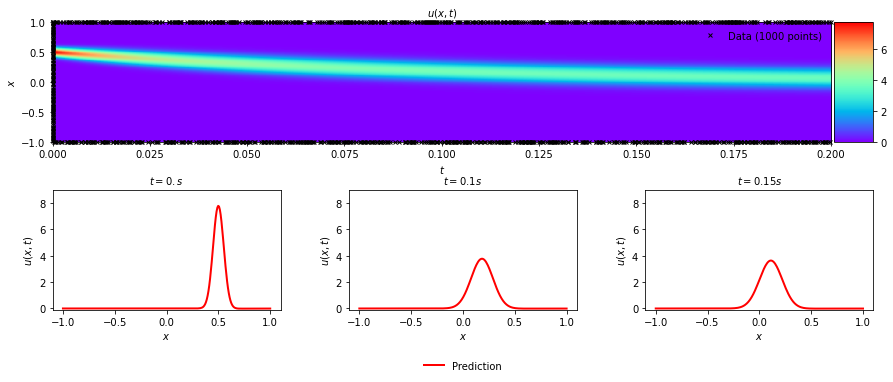

In [23]:
solutionplot(u_pred,X_u_train,u_train)

# Plot of collocation points

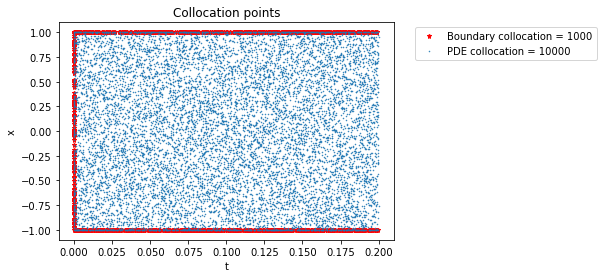

In [24]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [25]:
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

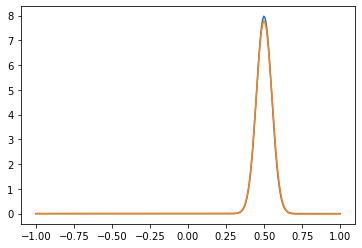

In [26]:
plt.plot(x, usol[:,0])
plt.plot(x, u_pred[:,0])

In [28]:
import ipywidgets
import pickle
filename = 'models/ornstein_uhlenbeck_lateral_ic.sav'
loaded_model = pickle.load(open(filename, 'rb')) #load model

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = Sequentialmodel(layers)
PINN.set_weights(loaded_model.x)
u_pred = PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  




def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, T.max() - T.max()/1000, T.max()/100))

interactive(children=(FloatSlider(value=0.049, description='time', max=0.0999, step=0.001), Output()), _dom_cl…

<function __main__.inter_pred(time)>